In [2]:
from main import *


# StratifiedCrossValidation
from sklearn.model_selection import train_test_split, StratifiedKFold

from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
machines = ["M01", "M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = Path("./data/").absolute()

In [4]:
X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label, add_additional_label = True, verbose = False)
    #concatenating
    X_data.extend(data_list)
    y_data.extend(data_label)

In [5]:
X = [x.astype(np.float64) for x in X_data] # Ensure all examples have the same datatype
X = np.array([x[:4096, :3] for x in X]) # Select the first 4096 timesteps of all three dimensions for each row
y = np.array([0 if id.split("_")[-1] == "good" else 1 for id in y_data])

# Reshape X into a dataframe that is compatible with MiniRocket transform
axis = ["X-axis", "Y-axis", "Z-axis"] 
axisdict = {"X-axis": [], "Y-axis":[],  "Z-axis":[]}
for i, ax in enumerate(axis):
    for n in range(X.shape[0]):
        axisdict[ax].append(pd.Series(X[n][:,i]))

X_df = pd.DataFrame(axisdict)

In [6]:
a = [y.split("_") for y in y_data]
y_df = pd.DataFrame(a)
df = X_df.join(y_df).rename(columns = {0: "MC", 1: "MM", 2: "YY", 3: "OP", 4: "n", 5: "y"})
df["y"] = df["y"].apply(lambda x: 1 if x == "bad" else 0)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.9, stratify = y)

skf = StratifiedKFold()
skf.get_n_splits(X_train, y_train)

for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {i}:")
    X_train_skf, y_train_skf = X_train.iloc[train_index], y_train[train_index]
    X_val, y_val = X_train.iloc[test_index], y_train[test_index] 

    trf = MiniRocketMultivariate(n_jobs = -1) 
    trf.fit(X_train_skf)
    X_train_skf_trf = trf.transform(X_train_skf)
    X_val_trf = trf.transform(X_val) 

    clf = LogisticRegression()

    clf.fit(X_train_skf_trf, y_train_skf)
    y_pred = clf.predict(X_val_trf)
    print(f1_score(y_val, y_pred))

Fold 0:
1.0
Fold 1:
1.0
Fold 2:
1.0
Fold 3:
1.0
Fold 4:
1.0


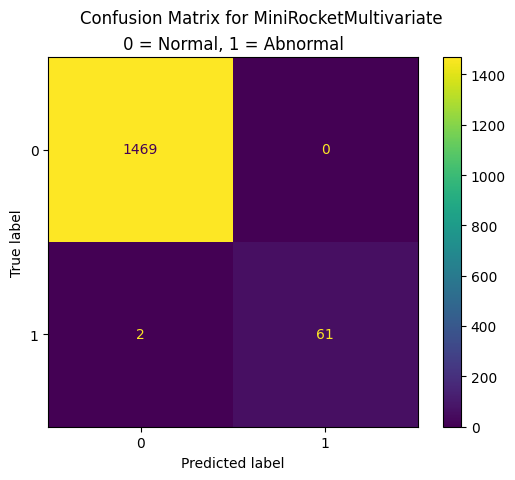

In [32]:
X_test_trf = trf.transform(X_test)
y_pred = clf.predict(X_test_trf)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.suptitle("Confusion Matrix for MiniRocketMultivariate")
plt.title("0 = Normal, 1 = Abnormal") 
plt.show()

In [35]:
f1_score(y_test, y_pred)
recall_score(y_test, y_pred)

np.float64(0.9682539682539683)

In [49]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.9, stratify = y)
trf = MiniRocketMultivariate(n_jobs = -1) 
trf.fit(X_train)
X_train_trf = trf.transform(X_train)
clf = LogisticRegression(n_jobs = -1)
params = {
    'C': [0.01, 0.1, 1, 10, 100]
}

gs = GridSearchCV(clf, params)

gs.fit(X_train_trf, y_train)

GridSearchCV(estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [50]:
clf_best = gs.best_estimator_
X_test_trf = trf.transform(X_test)
y_pred = clf_best.predict(X_test_trf)
print(f1_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.975609756097561
0.9523809523809523


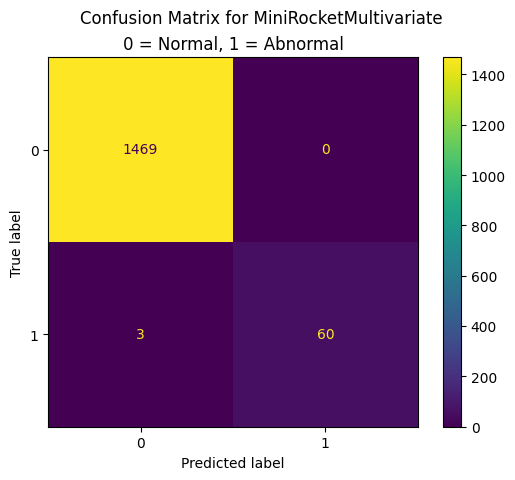

In [52]:
cm = confusion_matrix(y_test, y_pred, labels=clf_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_best.classes_)
disp.plot()
plt.suptitle("Confusion Matrix for MiniRocketMultivariate")
plt.title("0 = Normal, 1 = Abnormal") 
plt.show()

In [9]:
from sktime.classification.deep_learning.resnet import ResNetClassifier

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.8, stratify = y)

clf = ResNetClassifier(n_epochs = 50)

clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
f1_score(y_preds, y_test)

2024-11-10 15:04:01.789774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 15:04:01.907124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731247441.953339   24961 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731247441.967599   24961 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 15:04:02.079966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


np.float64(0.31547619047619047)

In [10]:
from sktime.classification.interval_based import DrCIF

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.8, stratify = y)

clf = DrCIF(
    n_estimators=3, n_intervals=2, att_subsample_size=2
) 

clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
f1_score(y_preds, y_test)

/home/tinus/nv/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/home/tinus/nv/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/home/tinus/nv/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/home/tinus/nv/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/home/tinus/nv/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._tran

np.float64(0.7526881720430108)

In [36]:
from sktime.registry import all_estimators, all_tags
names = []
estimators =[]
for name, estimator in all_estimators("classifier", filter_tags={"capability:multivariate": True}):
    names.append(name)
    estimators.append(estimator)

names

['Arsenal',
 'BaggingClassifier',
 'CNNClassifier',
 'CNTCClassifier',
 'CanonicalIntervalForest',
 'Catch22Classifier',
 'ColumnEnsembleClassifier',
 'DrCIF',
 'DummyClassifier',
 'FCNClassifier',
 'FreshPRINCE',
 'GRUClassifier',
 'GRUFCNNClassifier',
 'HIVECOTEV2',
 'InceptionTimeClassifier',
 'IndividualTDE',
 'KNeighborsTimeSeriesClassifier',
 'KNeighborsTimeSeriesClassifierTslearn',
 'LSTMFCNClassifier',
 'MACNNClassifier',
 'MCDCNNClassifier',
 'MLPClassifier',
 'MUSE',
 'MVTSTransformerClassifier',
 'MultiplexClassifier',
 'ProbabilityThresholdEarlyClassifier',
 'RandomIntervalClassifier',
 'ResNetClassifier',
 'RocketClassifier',
 'ShapeletLearningClassifierTslearn',
 'ShapeletTransformClassifier',
 'SignatureClassifier',
 'SimpleRNNClassifier',
 'SklearnClassifierPipeline',
 'SummaryClassifier',
 'TSCGridSearchCV',
 'TSFreshClassifier',
 'TapNetClassifier',
 'TemporalDictionaryEnsemble',
 'TimeSeriesSVC',
 'TimeSeriesSVCTslearn',
 'WeightedEnsembleClassifier']

In [26]:
['Arsenal',
 'BaggingClassifier',
 'CNNClassifier',
 'CNTCClassifier',
 'CanonicalIntervalForest',
 'Catch22Classifier',
 'ColumnEnsembleClassifier',
 'DrCIF',
 'DummyClassifier',
 'FCNClassifier',
 'FreshPRINCE',
 'GRUClassifier',
 'GRUFCNNClassifier',
 'HIVECOTEV2',
 'InceptionTimeClassifier',
 'IndividualTDE',
 'KNeighborsTimeSeriesClassifier',
 'KNeighborsTimeSeriesClassifierTslearn',
 'LSTMFCNClassifier',
 'MACNNClassifier',
 'MCDCNNClassifier',
 'MLPClassifier',
 'MUSE',
 'MVTSTransformerClassifier',
 'MultiplexClassifier',
 'ProbabilityThresholdEarlyClassifier',
 'RandomIntervalClassifier',
 'ResNetClassifier',
 'RocketClassifier',
 'ShapeletLearningClassifierTslearn',
 'ShapeletTransformClassifier',
 'SignatureClassifier',
 'SimpleRNNClassifier',
 'SklearnClassifierPipeline',
 'SummaryClassifier',
 'TSCGridSearchCV',
 'TSFreshClassifier',
 'TapNetClassifier',
 'TemporalDictionaryEnsemble',
 'TimeSeriesSVC',
 'TimeSeriesSVCTslearn',
 'WeightedEnsembleClassifier']

('Arsenal', sktime.classification.kernel_based._arsenal.Arsenal)

In [19]:
all_tags("classifier")

[('X_inner_mtype',
  'estimator',
  ('list', 'str'),
  'which machine type(s) is the internal _fit/_predict able to deal with?'),
 ('authors',
  'object',
  ('list', 'str'),
  'list of authors of the object, each author a GitHub handle'),
 ('capability:contractable',
  'estimator',
  'bool',
  'contract time setting, does the estimator support limiting max fit time?'),
 ('capability:feature_importance',
  'estimator',
  'bool',
  'Can the estimator provide feature importance?'),
 ('capability:missing_values',
  'object',
  'bool',
  'can the estimator handle missing data (NA, np.nan) in inputs?'),
 ('capability:multioutput',
  ['classifier', 'regressor'],
  'bool',
  'can the estimator handle multi-output time series?'),
 ('capability:multithreading',
  ['classifier', 'early_classifier'],
  'bool',
  'can the classifier set n_jobs to use multiple threads?'),
 ('capability:multivariate',
  ['classifier',
   'clusterer',
   'early_classifier',
   'param_est',
   'regressor',
   'transfor